#IMPORT NECESSARY LIBRARIES

In [1]:
import os
import random
random.seed(42) # Set random seed for reproducibility
import time
import math
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_3013396/2250032840.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
from mpl_toolkits.mplot3d import Axes3D
from skimage import io
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import RandomOverSampler
import imgaug.augmenters as iaa

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR
from torch.utils.data import Dataset, DataLoader
# from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.distributed import DistributedSampler
import torch.multiprocessing as mp
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

/storage/phucpg/venv/v05/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# !pip install efficientnet_pytorch
# !pip install pytorch-dpn-pretrained
# !pip install timm
from efficientnet_pytorch import EfficientNet
import torch.hub

##Define runtime

In [5]:
# !pip install ipython-autotime
%load_ext autotime

time: 172 µs (started: 2024-09-04 17:25:06 -04:00)


##Define GPU usage

In [6]:
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")


Available GPUs:
GPU 0: Tesla K80
GPU 1: Tesla K80
GPU 2: Tesla K80
GPU 3: Tesla K80
GPU 4: Tesla K80
GPU 5: Tesla K80
GPU 6: Tesla K80
GPU 7: Tesla K80
time: 393 ms (started: 2024-09-04 17:25:06 -04:00)


In [7]:
# Set the GPU device
gpu_index = 0  # Change the index for each file (0 to 7)
if gpu_index < torch.cuda.device_count():
    torch.cuda.set_device(gpu_index)
    device = torch.device(f"cuda:{gpu_index}")
    print(f"Using GPU {gpu_index}: {torch.cuda.get_device_name(gpu_index)}")
else:
    print(f"Invalid GPU index: {gpu_index}. Please choose an index between 0 and {torch.cuda.device_count() - 1}.")


Using GPU 0: Tesla K80
time: 18.6 ms (started: 2024-09-04 17:25:06 -04:00)


#DATA PREPARATION

##Get and Import dataset

In [8]:
data_dir = '../data/ISIC_2019'

training_input_zip = data_dir + '/ISIC_2019_Training_Input.zip'
test_input_zip = data_dir + '/ISIC_2019_Test_Input.zip'

training_Metadata = data_dir + '/ISIC_2019_Training_Metadata.csv'
training_GroundTruth =  data_dir + '/ISIC_2019_Training_GroundTruth.csv'
test_Metadata = data_dir + '/ISIC_2019_Test_Metadata.csv'

# !unzip "$training_input_zip"
# !unzip "$test_input_zip"

training_input_dir = data_dir + '/ISIC_2019_Training_Input'
test_input_dir = data_dir + '/ISIC_2019_Test_Input'

time: 2.24 ms (started: 2024-09-04 17:25:06 -04:00)


###Meta-data

In [9]:
train_metadata=pd.read_csv(training_Metadata)
train_metadata

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male
...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female


time: 106 ms (started: 2024-09-04 17:25:06 -04:00)


In [10]:
train_groundtruth=pd.read_csv(training_GroundTruth)
# # Drop the 'UNK' column
# train_groundtruth = train_groundtruth.drop(columns=['UNK'])
train_groundtruth

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 50.2 ms (started: 2024-09-04 17:25:06 -04:00)


In [11]:
test_metadata=pd.read_csv(test_Metadata)
test_metadata

,image,age_approx,anatom_site_general,sex
0,ISIC_0034321,60.0,NaN,female
1,ISIC_0034322,70.0,anterior torso,male
2,ISIC_0034323,70.0,lower extremity,male
3,ISIC_0034324,70.0,lower extremity,male
4,ISIC_0034325,30.0,upper extremity,female
...,...,...,...,...
8233,ISIC_0073236,75.0,anterior torso,male
8234,ISIC_0073243,65.0,lower extremity,male
8235,ISIC_0073250,30.0,anterior torso,female
8236,ISIC_0073252,85.0,head/neck,female


time: 22 ms (started: 2024-09-04 17:25:06 -04:00)


###Meta-data information

In [12]:
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB
time: 11.9 ms (started: 2024-09-04 17:25:06 -04:00)


In [13]:
train_groundtruth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   25331 non-null  object 
 1   MEL     25331 non-null  float64
 2   NV      25331 non-null  float64
 3   BCC     25331 non-null  float64
 4   AK      25331 non-null  float64
 5   BKL     25331 non-null  float64
 6   DF      25331 non-null  float64
 7   VASC    25331 non-null  float64
 8   SCC     25331 non-null  float64
 9   UNK     25331 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.9+ MB
time: 7.77 ms (started: 2024-09-04 17:25:06 -04:00)


In [14]:
test_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8238 entries, 0 to 8237
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                8238 non-null   object 
 1   age_approx           7912 non-null   float64
 2   anatom_site_general  7583 non-null   object 
 3   sex                  7899 non-null   object 
dtypes: float64(1), object(3)
memory usage: 257.6+ KB
time: 6.21 ms (started: 2024-09-04 17:25:06 -04:00)


##DATA PREPROCESSING

###Original data information

In [15]:
train_metadata.info()
print()
# train_metadata.head()
print(train_metadata.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB

Index(['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex'], dtype='object')
time: 9.8 ms (started: 2024-09-04 17:25:07 -04:00)


###Data cleansing

identifying and correcting errors or inconsistencies in the data.

In [16]:
# Convert the train_groundtruth DataFrame from wide format to long format
melted_groundtruth = train_groundtruth.melt(id_vars='image', var_name='disease_type', value_name='presence')


# THIS LINE REMOVE UNK COLUMN
# Filter out rows where presence is 0 (i.e., the disease type is not present)
filtered_groundtruth = melted_groundtruth[melted_groundtruth['presence'] == 1]

# Merge the train_metadata and filtered_groundtruth DataFrames on the 'image' column
combined_train_df = pd.merge(train_metadata, filtered_groundtruth, on='image')

print(combined_train_df.columns)

Index(['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex',
       'disease_type', 'presence'],
      dtype='object')
time: 41.1 ms (started: 2024-09-04 17:25:07 -04:00)


In [17]:
# Removing duplicate rows
train_metadata_pp = combined_train_df.drop_duplicates()

# Removing rows with missing values
train_metadata_pp = train_metadata_pp.dropna()

# Replace missing values in 'age' column with median age
median_age = train_metadata_pp['age_approx'].median()
train_metadata_pp['age_approx'] = train_metadata_pp['age_approx'].fillna(median_age)

# Fixing column names
train_metadata_pp = train_metadata_pp.rename(columns={
    'image': 'Image_Id',
    'age_approx': 'Age',
    'anatom_site_general': 'Region_Of_Disease',
    'lesion_id': 'Lesion_Id',
    'sex': 'Sex',
    'disease_type': 'Disease_Type',
    'presence': 'Presence'
})

# Define the mapping of current values to new values
diagnosis_mapping = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic Nevi',
    'BCC': 'Basal Cell Carcinoma',
    'AK': 'Actinic Keratoses',
    'BKL': 'Benign Keratosis-Like Lesions',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular Lesions',
    'SCC': 'Squamous Cell Carcinoma',
    'UNK': 'Unknown'
}

# Convert the Age column to integers
train_metadata_pp['Age'] = train_metadata_pp['Age'].astype(int)

# Create a new column with the updated diagnosis names
train_metadata_pp['Diagnosis'] = train_metadata_pp['Disease_Type'].map(diagnosis_mapping)

time: 29.6 ms (started: 2024-09-04 17:25:07 -04:00)


In [18]:
train_metadata_pp.info()
print()
train_metadata_pp

<class 'pandas.core.frame.DataFrame'>
Index: 21311 entries, 1459 to 25330
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_Id           21311 non-null  object 
 1   Age                21311 non-null  int64  
 2   Region_Of_Disease  21311 non-null  object 
 3   Lesion_Id          21311 non-null  object 
 4   Sex                21311 non-null  object 
 5   Disease_Type       21311 non-null  object 
 6   Presence           21311 non-null  float64
 7   Diagnosis          21311 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 1.5+ MB



,Image_Id,Age,Region_Of_Disease,Lesion_Id,Sex,Disease_Type,Presence,Diagnosis
1459,ISIC_0012653_downsampled,50,posterior torso,MSK4_0011169,female,NV,1.0,Melanocytic Nevi
1460,ISIC_0012654_downsampled,30,lower extremity,MSK4_0011170,female,NV,1.0,Melanocytic Nevi
1461,ISIC_0012655_downsampled,35,upper extremity,MSK4_0011171,female,NV,1.0,Melanocytic Nevi
1462,ISIC_0012656_downsampled,45,posterior torso,MSK4_0011172,male,NV,1.0,Melanocytic Nevi
1463,ISIC_0012657_downsampled,20,upper extremity,MSK4_0011173,female,NV,1.0,Melanocytic Nevi
...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,85,head/neck,BCN_0003925,female,BCC,1.0,Basal Cell Carcinoma
25327,ISIC_0073248,65,anterior torso,BCN_0001819,male,BKL,1.0,Benign Keratosis-Like Lesions
25328,ISIC_0073249,70,lower extremity,BCN_0001085,male,MEL,1.0,Melanoma
25329,ISIC_0073251,55,palms/soles,BCN_0002083,female,NV,1.0,Melanocytic Nevi


time: 22.7 ms (started: 2024-09-04 17:25:07 -04:00)


###Get images data

finish preprocessing

In [19]:
# Map image paths
train_image_dir = training_input_dir
image_paths = [os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir)]
image_path_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in image_paths}
train_metadata_pp['Image_path'] = train_metadata_pp['Image_Id'].map(image_path_dict)

train_metadata_pp

,Image_Id,Age,Region_Of_Disease,Lesion_Id,Sex,Disease_Type,Presence,Diagnosis,Image_path
1459,ISIC_0012653_downsampled,50,posterior torso,MSK4_0011169,female,NV,1.0,Melanocytic Nevi,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
1460,ISIC_0012654_downsampled,30,lower extremity,MSK4_0011170,female,NV,1.0,Melanocytic Nevi,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
1461,ISIC_0012655_downsampled,35,upper extremity,MSK4_0011171,female,NV,1.0,Melanocytic Nevi,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
1462,ISIC_0012656_downsampled,45,posterior torso,MSK4_0011172,male,NV,1.0,Melanocytic Nevi,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
1463,ISIC_0012657_downsampled,20,upper extremity,MSK4_0011173,female,NV,1.0,Melanocytic Nevi,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,85,head/neck,BCN_0003925,female,BCC,1.0,Basal Cell Carcinoma,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
25327,ISIC_0073248,65,anterior torso,BCN_0001819,male,BKL,1.0,Benign Keratosis-Like Lesions,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
25328,ISIC_0073249,70,lower extremity,BCN_0001085,male,MEL,1.0,Melanoma,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
25329,ISIC_0073251,55,palms/soles,BCN_0002083,female,NV,1.0,Melanocytic Nevi,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...


time: 12.4 s (started: 2024-09-04 17:25:07 -04:00)


In [20]:
# train_metadata_pp = train_metadata_pp.sample(n=2000, random_state=42) # remove this line for full dataset
train_metadata_pp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21311 entries, 1459 to 25330
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_Id           21311 non-null  object 
 1   Age                21311 non-null  int64  
 2   Region_Of_Disease  21311 non-null  object 
 3   Lesion_Id          21311 non-null  object 
 4   Sex                21311 non-null  object 
 5   Disease_Type       21311 non-null  object 
 6   Presence           21311 non-null  float64
 7   Diagnosis          21311 non-null  object 
 8   Image_path         21311 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 1.6+ MB
time: 18.8 ms (started: 2024-09-04 17:25:19 -04:00)


###Correctting image paths

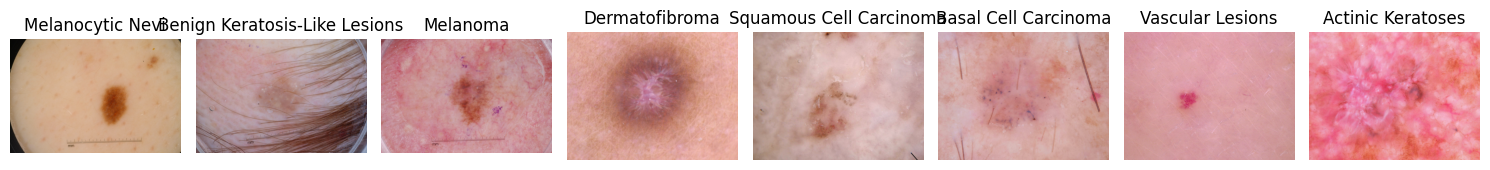

time: 29.5 s (started: 2024-09-04 17:25:19 -04:00)


In [21]:
# Ensure that the image paths are correct and accessible
for i in range(len(train_metadata_pp)):
    if not os.path.isfile(train_metadata_pp['Image_path'].iloc[i]):
        raise FileNotFoundError(f"Image file not found: {train_metadata_pp['Image_path'].iloc[i]}")

# Get one image per class
class_images = train_metadata_pp.drop_duplicates(subset='Diagnosis')

# Plot one image per class
def plot_class_images(class_images):
    plt.figure(figsize=(15, 5))
    num_classes = len(class_images)
    for i in range(num_classes):
        plt.subplot(1, num_classes, i + 1)
        img = plt.imread(class_images['Image_path'].iloc[i])
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_images['Diagnosis'].iloc[i], fontsize=12)
    plt.tight_layout()
    plt.show()

# Call the function to plot images
plot_class_images(class_images)

#MODEL IMPLEMENTATION

##Prepare data for training process

###Label Encoder

In [22]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder and transform 'Region_Of_Disease' column
train_metadata_pp['Diagnosis_Label'] = label_encoder.fit_transform(train_metadata_pp['Diagnosis'])

# Display the mapping between original labels and encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
print(label_mapping)

Label Encoding Mapping:
{'Actinic Keratoses': 0, 'Basal Cell Carcinoma': 1, 'Benign Keratosis-Like Lesions': 2, 'Dermatofibroma': 3, 'Melanocytic Nevi': 4, 'Melanoma': 5, 'Squamous Cell Carcinoma': 6, 'Vascular Lesions': 7}
time: 5.45 ms (started: 2024-09-04 17:25:49 -04:00)


###Augment and transfrom dataset

In [23]:
# Data augmentation and transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 299x299
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(180),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

time: 17.3 ms (started: 2024-09-04 17:25:49 -04:00)


###Split data

In [24]:
# Split the dataset into train and temp (80% train, 20% temp)
train_df, temp_df = train_test_split(train_metadata_pp, test_size=0.2, stratify=train_metadata_pp['Diagnosis_Label'], random_state=42)

# Split the temp dataset into validation and test (50% val, 50% test of the 20% temp)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Diagnosis_Label'], random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 17048
Validation set size: 2131
Test set size: 2132
time: 25.1 ms (started: 2024-09-04 17:25:49 -04:00)


###Balancing dataset

In [25]:
# Separate features and labels for balancing
X_train = train_df.drop(columns=['Diagnosis_Label'])
y_train = train_df['Diagnosis_Label']

# Apply RandomOverSampler only to the training set
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Combine resampled features and labels into a DataFrame
train_df_resampled = X_resampled.copy()
train_df_resampled['Diagnosis_Label'] = y_resampled

print(f"Resampled training set size: {len(train_df_resampled)}")

Resampled training set size: 62368
time: 58.9 ms (started: 2024-09-04 17:25:49 -04:00)


In [26]:
# # Separate features and labels for balancing
# X_train = train_df.drop(columns=['Diagnosis_Label'])
# y_train = train_df['Diagnosis_Label']

# # Combine resampled features and labels into a DataFrame
# train_df_resampled = X_train
# train_df_resampled['Diagnosis_Label'] = y_train

# print(f"Resampled training set size: {len(train_df_resampled)}")

time: 331 µs (started: 2024-09-04 17:25:49 -04:00)


###Load dataset

In [55]:
#  make easily load and preprocess dataset -> compatible with PyTorch’s data loading utilities.
class LoadedDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Image_path']
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['Diagnosis_Label']

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets and dataloaders
train_dataset = LoadedDataset(train_df_resampled, transform=transform)
val_dataset = LoadedDataset(val_df, transform=transform)
test_dataset = LoadedDataset(test_df, transform=transform)

# Modify DataLoader to use DistributedSampler
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8,
                          persistent_workers=True,
                          pin_memory=True
                         )
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=8,
                        persistent_workers=True,
                        pin_memory=True
                       )
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8,
                         persistent_workers=True,
                         pin_memory=True
                        )

# Example of iterating through the dataloader and printing results
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    print(f"Labels: {labels}")

    print("Label Mapping:", label_mapping)
    print("Unique Labels in Dataset:", train_metadata_pp['Diagnosis_Label'].unique())

    break  # Print only the first batch

Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels shape: torch.Size([32])
Labels: tensor([7, 6, 4, 5, 1, 3, 0, 2, 0, 7, 4, 6, 0, 2, 7, 7, 0, 3, 3, 7, 7, 5, 6, 3,
        2, 2, 4, 1, 1, 7, 4, 7])
Label Mapping: {'Actinic Keratoses': 0, 'Basal Cell Carcinoma': 1, 'Benign Keratosis-Like Lesions': 2, 'Dermatofibroma': 3, 'Melanocytic Nevi': 4, 'Melanoma': 5, 'Squamous Cell Carcinoma': 6, 'Vascular Lesions': 7}
Unique Labels in Dataset: [4 2 5 3 6 1 7 0]
time: 2.08 s (started: 2024-09-06 07:22:20 -04:00)


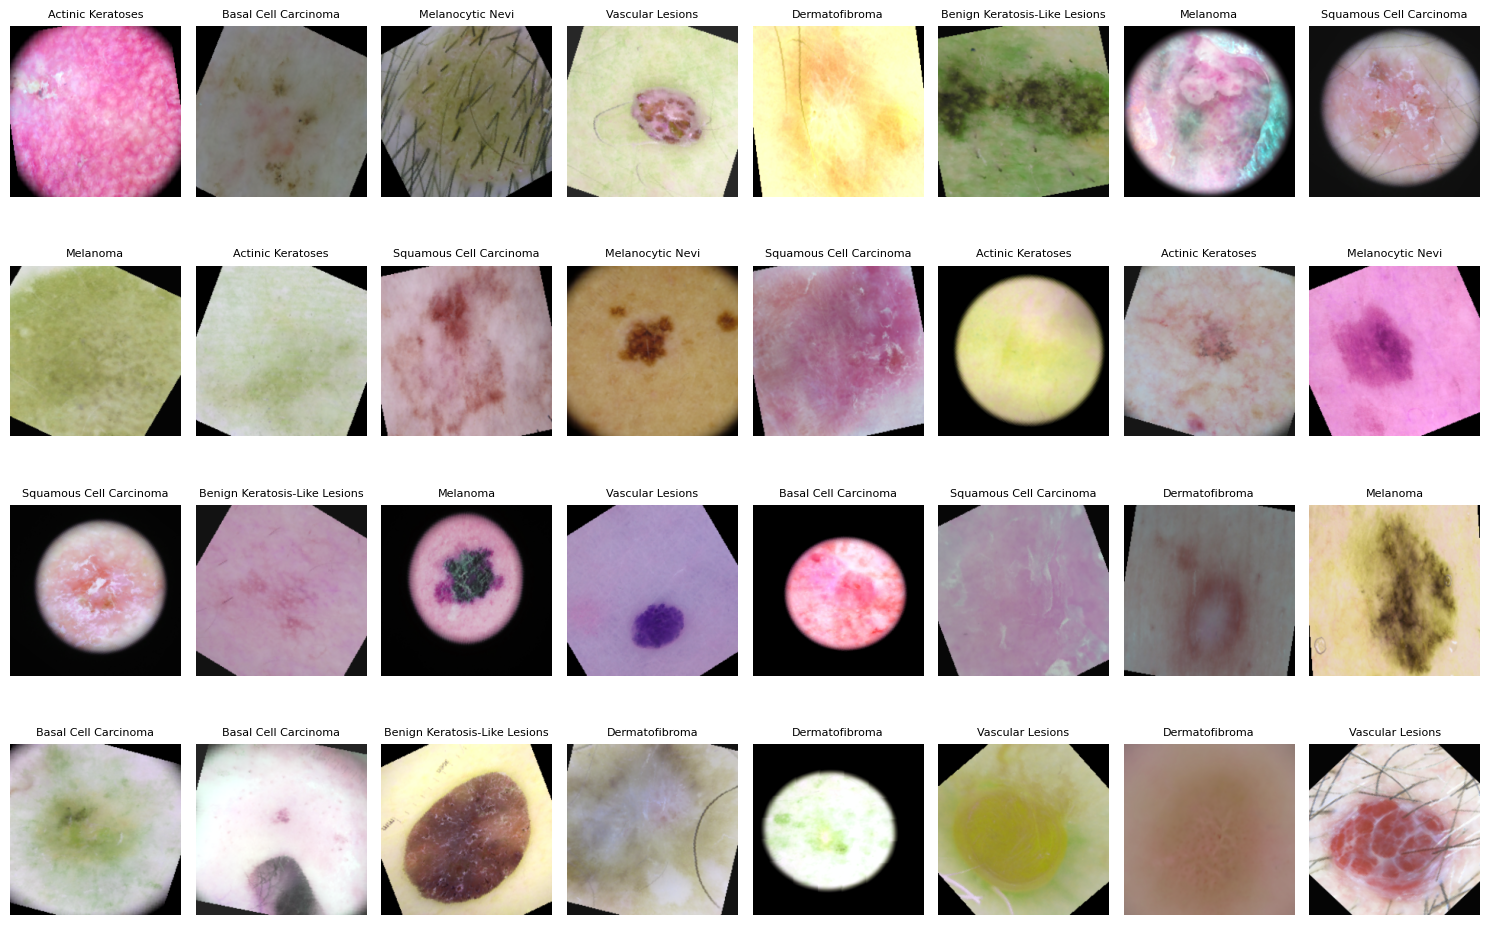

time: 5.43 s (started: 2024-09-04 17:25:53 -04:00)


In [28]:
# Function to plot a batch of images
def plot_batch_images(images, labels, label_mapping):
    num_images = len(images)
    num_cols = 8
    num_rows = math.ceil(num_images / num_cols)

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)

        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and rearrange dimensions
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
        img = np.clip(img, 0, 1)  # Clip values to be in the range [0, 1]
        plt.imshow(img)
        plt.axis('off')

        label = labels[i].item()
        label_name = list(label_mapping.keys())[list(label_mapping.values()).index(label)]  # Get label name
        plt.title(label_name, fontsize=8)

    plt.tight_layout()
    plt.show()

# Get a batch of training data
images, labels = next(iter(train_loader))

# Plot the batch of images
plot_batch_images(images, labels, label_mapping)


##Model functionalities

###Load pre-trained and construct models

####Load pretrained models

In [29]:
class CustomEfficientNet(nn.Module):
    def __init__(self, model_name, num_classes, unfreeze_layers=0):
        super(CustomEfficientNet, self).__init__()
        self.model = EfficientNet.from_pretrained(model_name)
        num_ftrs = self.model._fc.in_features
        self.model._fc = nn.Identity()  # Remove the top layer

        # Add new top layers
        self.new_top = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global Average Pooling
            nn.Flatten(),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 256, bias=False),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, num_classes)
        )

        # Freeze all layers
        self.freeze_all_layers()

        # Unfreeze the specified number of layers
        if unfreeze_layers > 0:
            self.unfreeze_layers(unfreeze_layers)

    def forward(self, x):
        x = self.model.extract_features(x)
        x = self.new_top(x)
        return x

    def freeze_all_layers(self):
        for param in self.model.parameters():
            param.requires_grad = False

    def unfreeze_layers(self, num_layers):
        # Unfreeze the last `num_layers` layers
        layers = list(self.model.children())
        for layer in layers[-num_layers:]:
            for param in layer.parameters():
                param.requires_grad = True


time: 2.22 ms (started: 2024-09-04 17:25:58 -04:00)


In [30]:
class CustomShuffleNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomShuffleNet, self).__init__()
        self.model = models.shufflenet_v2_x1_0(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Identity()  # Remove the top layer

        # Add new top layers
        self.new_top = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global Average Pooling with specific output size
            nn.Flatten(),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256, bias=False),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        # Freeze all layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze the final layer
        for param in self.new_top.parameters():
            param.requires_grad = True

        # Unfreeze additional layers if specified
        if unfreeze_layers > 0:
            layer_count = 0
            for name, param in model.named_parameters():
                if not param.requires_grad:
                    param.requires_grad = True
                    layer_count += 1
                    if layer_count >= unfreeze_layers:
                        break

    def forward(self, x):
        x = self.model(x)
        if len(x.shape) == 2:
            x = x.unsqueeze(-1).unsqueeze(-1)  # Add height and width dimensions if missing
        # print(f"Shape after feature extraction: {x.shape}")
        x = self.new_top(x)
        # print(f"Shape after new top layers: {x.shape}")
        return x


time: 2.17 ms (started: 2024-09-04 17:25:58 -04:00)


In [31]:
def create_model(model_name, num_classes, unfreeze_blocks=0):
    if model_name == 'efficientnet-b0':
        return CustomEfficientNet(model_name, num_classes, unfreeze_blocks)
    elif model_name == 'shufflenet_v2_x1_0':
        return CustomShuffleNet(num_classes)
    else:
        raise ValueError("Invalid model name.")

time: 3.59 ms (started: 2024-09-04 17:25:58 -04:00)


###Training activities

In [32]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, patience=5, threshold=0.5, save_dir='best_model'):
    best_val_loss = np.inf
    best_val_acc = 0.0
    patience_counter = 0
    metrics = {
        'Train Loss': [],
        'Train Accuracy': [],
        'Val Loss': [],
        'Val Accuracy': [],
        'Learning Rate': []  # Track learning rate
    }
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Start the timer
    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=200)  # Adjust ncols to set the width
        num_batches = len(train_loader)
        validate_every_n_batches = max(1, num_batches // 10)  # Calculate the number of batches for 10% progress

        val_loss = None
        val_acc = None

        for batch_idx, (images, labels) in enumerate(progress_bar):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()  # Backpropagation
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_loss = running_loss / (batch_idx + 1)
            train_acc = 100 * correct / total

            if (batch_idx + 1) % validate_every_n_batches == 0 or (batch_idx + 1) == num_batches:
                val_loss, val_acc, _, _ = validate_model(model, val_loader, criterion, threshold)

            progress_bar.set_postfix({
                'Train Loss': f'{train_loss:.4f}',
                'Train Accuracy': f'{train_acc:.2f}%',
                'Val Loss': f'{val_loss:.4f}' if val_loss is not None else '[]',
                'Val Accuracy': f'{val_acc:.2f}%' if val_acc is not None else '[]'
            })
            progress_bar.refresh()

        val_loss, val_acc, all_preds, all_labels = validate_model(model, val_loader, criterion, threshold)

        # Store final metrics for the epoch
        metrics['Train Loss'].append(train_loss)
        metrics['Train Accuracy'].append(train_acc)
        metrics['Val Loss'].append(val_loss)
        metrics['Val Accuracy'].append(val_acc)
        metrics['Learning Rate'].append(optimizer.param_groups[0]['lr'])  # Track learning rate
        
        scheduler.step(val_loss)  # Step the scheduler
        
        # Early stopping
        if val_loss < best_val_loss or val_acc > best_val_acc:
            # if val_loss < best_val_loss:
            #     best_val_loss = val_loss
            # if val_acc > best_val_acc:
            #     best_val_acc = val_acc
            best_val_loss = val_loss
            best_val_acc = val_acc
            patience_counter = 0
            
            # Save the best model
            model_save_path = os.path.join(save_dir, f'{model_name}_best.pth')
            torch.save({
                'epoch': epoch + 1, # Adjust the epoch number
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
                'learning_rate': optimizer.param_groups[0]['lr']  # Save learning rate
            }, model_save_path)

            # Print success message
            print(f'Model {model_name} at epoch {epoch + 1} with accuracy of {val_acc:.2f}% and loss of {val_loss:.4f} is saved to "{model_save_path}" successfully.')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

        
        
    # End the timer
    end_time = time.time()
    total_time = end_time - start_time

    # Print overall model accuracy on the validation set
    print(f"Overall Validation Accuracy: {val_acc:.2f}%")
    print(f"Total Training Time: {total_time:.2f} seconds")
    
    return metrics


time: 3.13 ms (started: 2024-09-04 17:25:58 -04:00)


In [33]:
def validate_model(model, val_loader, criterion, threshold=0.5):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            probabilities = torch.softmax(outputs, dim=1)
            max_probs, predicted = torch.max(probabilities, 1)
            confident_preds = (max_probs >= threshold).long() * predicted
            total += labels.size(0)
            correct += (confident_preds == labels).sum().item()

            all_preds.extend(confident_preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(val_loader)
    val_acc = 100 * correct / total

    return val_loss, val_acc, all_preds, all_labels


time: 2.14 ms (started: 2024-09-04 17:25:58 -04:00)


###Complexity measurement

In [34]:
# Function to measure training time
def measure_training_time(model, train_loader, criterion, optimizer, num_epochs=1):
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Relative Training Time of 1 Epoch: {training_time:.2f} seconds")

# Function to measure inference time
def measure_inference_time(model, test_loader):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
    end_time = time.time()
    inference_time = end_time - start_time
    print(f"Total Inference Time: {inference_time:.2f} seconds")

# Function to measure memory usage
def measure_memory_usage(model, train_loader):
    model.train()
    torch.cuda.reset_peak_memory_stats(device)
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    peak_memory = torch.cuda.max_memory_allocated(device)
    print(f"Peak Memory Usage: {peak_memory / (1024 ** 2):.2f} MB")

time: 1.73 ms (started: 2024-09-04 17:25:58 -04:00)


###Visualize training result

In [35]:
def plot_metrics(metrics):
    epochs = range(1, len(metrics['Train Loss']) + 1)

    # # Debugging: Print the metrics to check their contents
    # print("Train Loss:", metrics['Train Loss'])
    # print("Val Loss:", metrics['Val Loss'])
    # print("Learning Rate:", metrics['Learning Rate'])
    
    fig, ax1 = plt.subplots(1, 2, figsize=(12, 4))

    # Plotting Training and Validation Loss
    ax1[0].plot(epochs, metrics['Train Loss'], label='Train Loss')
    ax1[0].plot(epochs, metrics['Val Loss'], label='Val Loss')
    ax1[0].set_xlabel('Epochs')
    ax1[0].set_ylabel('Loss')
    ax1[0].set_title('Training and Validation Loss')

    ax2_0 = ax1[0].twinx()
    ax2_0.plot(epochs, metrics['Learning Rate'], label='Learning Rate', color='r', linestyle='--')
    ax2_0.set_ylabel('Learning Rate')

    # Combine legends for Loss
    lines_0, labels_0 = ax1[0].get_legend_handles_labels()
    lines_2_0, labels_2_0 = ax2_0.get_legend_handles_labels()
    ax1[0].legend(lines_0 + lines_2_0, labels_0 + labels_2_0, loc='upper right')

    # Plotting Training and Validation Accuracy
    ax1[1].plot(epochs, metrics['Train Accuracy'], label='Train Accuracy')
    ax1[1].plot(epochs, metrics['Val Accuracy'], label='Val Accuracy')
    ax1[1].set_xlabel('Epochs')
    ax1[1].set_ylabel('Accuracy')
    ax1[1].set_title('Training and Validation Accuracy')

    ax2_1 = ax1[1].twinx()
    ax2_1.plot(epochs, metrics['Learning Rate'], label='Learning Rate', color='r', linestyle='--')
    ax2_1.set_ylabel('Learning Rate')

    # Combine legends for Accuracy
    lines_1, labels_1 = ax1[1].get_legend_handles_labels()
    lines_2_1, labels_2_1 = ax2_1.get_legend_handles_labels()
    ax1[1].legend(lines_1 + lines_2_1, labels_1 + labels_2_1, loc='upper left')

    plt.tight_layout()
    plt.show()


time: 1.9 ms (started: 2024-09-04 17:25:58 -04:00)


In [36]:
def plot_metrics(metrics):
    epochs = range(1, len(metrics['Train Loss']) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics['Train Loss'], label='Train Loss')
    plt.plot(epochs, metrics['Val Loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics['Train Accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics['Val Accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()

time: 2.05 ms (started: 2024-09-04 17:25:58 -04:00)


In [37]:
def visualize_predictions(model, val_loader, label_mapping, criterion, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))  # Decrease the figure size

    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {list(label_mapping.keys())[preds[j]]}\n'
                             f'Actual: {list(label_mapping.keys())[labels[j]]}\n'
                             f'Loss: {loss.item():.2f}\n'
                             f'Accuracy: {(preds[j] == labels[j]).item() * 100:.2f}%', fontsize=14)  # Increase text size
                img = images.cpu().data[j].numpy().transpose((1, 2, 0))
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    plt.tight_layout()
                    return


time: 3.32 ms (started: 2024-09-04 17:25:58 -04:00)


In [38]:
def plot_confusion_matrix(model, test_loader, label_mapping):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_labels = list(label_mapping.keys())

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

time: 1.32 ms (started: 2024-09-04 17:25:59 -04:00)


In [39]:
def plot_normalize_confusion_matrix(model, test_loader, label_mapping):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_labels = list(label_mapping.keys())

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Normalized Confusion Matrix')
    plt.show()

time: 2.08 ms (started: 2024-09-04 17:25:59 -04:00)


##Model definition

In [40]:
# torch.cuda.empty_cache()

# Construct the model for training process
model_name = 'efficientnet-b0'
num_classes = len(label_mapping)
unfreeze_layers = 9  # Number of additional layers to unfreeze

model = create_model(model_name, num_classes, unfreeze_layers)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)  # Move the model to the device

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Transfer learning model
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Configuration for training process
num_epochs = 50
threshold = 0.5
patience = 10
save_dir = 'saved_models'  # Save the best model to this location

Loaded pretrained weights for efficientnet-b0
time: 148 ms (started: 2024-09-04 17:25:59 -04:00)


##Complexity measurement

In [41]:
# Measure training time
measure_training_time(model, train_loader, criterion, optimizer, num_epochs=1)

# Measure memory usage during training
measure_memory_usage(model, train_loader)

# Measure inference time
measure_inference_time(model, test_loader)

Relative Training Time of 1 Epoch: 773.01 seconds
Peak Memory Usage: 454.72 MB
Total Inference Time: 15.63 seconds
time: 25min 43s (started: 2024-09-04 08:03:35 -04:00)


##Train the model

In [42]:
# Start training
metrics = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience=patience, threshold=threshold, save_dir=save_dir)

Epoch 1/40: 100%|███████████████████████████████████████████████████████████████████| 1949/1949 [14:26<00:00,  2.25it/s, Train Loss=0.7100, Train Accuracy=74.34%, Val Loss=0.9068, Val Accuracy=57.20%]


Model efficientnet-b0 at epoch 1 with accuracy of 58.38% and loss of 0.8844 is saved to "saved_models/efficientnet-b0_best.pth" successfully.


Epoch 3/40: 100%|███████████████████████████████████████████████████████████████████| 1949/1949 [14:38<00:00,  2.22it/s, Train Loss=0.4911, Train Accuracy=82.47%, Val Loss=0.9334, Val Accuracy=63.26%]


Model efficientnet-b0 at epoch 3 with accuracy of 63.21% and loss of 0.9392 is saved to "saved_models/efficientnet-b0_best.pth" successfully.


Epoch 5/40: 100%|███████████████████████████████████████████████████████████████████| 1949/1949 [14:38<00:00,  2.22it/s, Train Loss=0.4067, Train Accuracy=85.57%, Val Loss=1.0042, Val Accuracy=62.04%]


Epoch     5: reducing learning rate of group 0 to 1.0000e-04.


Epoch 6/40: 100%|███████████████████████████████████████████████████████████████████| 1949/1949 [14:32<00:00,  2.23it/s, Train Loss=0.2465, Train Accuracy=91.17%, Val Loss=0.9251, Val Accuracy=73.06%]


Model efficientnet-b0 at epoch 6 with accuracy of 72.45% and loss of 0.9010 is saved to "saved_models/efficientnet-b0_best.pth" successfully.


Epoch 9/40:  79%|████████████████████████████████████████████████████▋              | 1531/1949 [10:51<02:16,  3.06it/s, Train Loss=0.1767, Train Accuracy=93.74%, Val Loss=1.0080, Val Accuracy=72.50%]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=30.0 (secs)

Epoch 13/40: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:36<00:00,  2.22it/s, Train Loss=0.1475, Train Accuracy=94.81%, Val Loss=0.9752, Val Accuracy=73.91%]


Epoch    13: reducing learning rate of group 0 to 1.0000e-06.


Epoch 14/40: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:28<00:00,  2.24it/s, Train Loss=0.1608, Train Accuracy=94.41%, Val Loss=0.8888, Val Accuracy=74.66%]


Model efficientnet-b0 at epoch 14 with accuracy of 74.47% and loss of 0.8920 is saved to "saved_models/efficientnet-b0_best.pth" successfully.


Epoch 15/40: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:29<00:00,  2.24it/s, Train Loss=0.1619, Train Accuracy=94.60%, Val Loss=0.8666, Val Accuracy=74.80%]


Model efficientnet-b0 at epoch 15 with accuracy of 75.36% and loss of 0.8620 is saved to "saved_models/efficientnet-b0_best.pth" successfully.


Epoch 19/40: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:18<00:00,  2.27it/s, Train Loss=0.1595, Train Accuracy=94.52%, Val Loss=0.8997, Val Accuracy=75.36%]


Epoch    19: reducing learning rate of group 0 to 1.0000e-07.


Epoch 20/40: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:23<00:00,  2.26it/s, Train Loss=0.1788, Train Accuracy=94.03%, Val Loss=0.8193, Val Accuracy=72.97%]


Model efficientnet-b0 at epoch 20 with accuracy of 72.50% and loss of 0.8129 is saved to "saved_models/efficientnet-b0_best.pth" successfully.


Epoch 21/40: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:22<00:00,  2.26it/s, Train Loss=0.1833, Train Accuracy=94.05%, Val Loss=0.8232, Val Accuracy=72.64%]


Model efficientnet-b0 at epoch 21 with accuracy of 73.49% and loss of 0.7933 is saved to "saved_models/efficientnet-b0_best.pth" successfully.


Epoch 24/40: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:06<00:00,  2.30it/s, Train Loss=0.1825, Train Accuracy=94.03%, Val Loss=0.7975, Val Accuracy=73.49%]


Model efficientnet-b0 at epoch 24 with accuracy of 74.00% and loss of 0.7942 is saved to "saved_models/efficientnet-b0_best.pth" successfully.


Epoch 25/40: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:17<00:00,  2.27it/s, Train Loss=0.1827, Train Accuracy=94.02%, Val Loss=0.8107, Val Accuracy=72.88%]


Epoch    25: reducing learning rate of group 0 to 1.0000e-08.


Epoch 26/40: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:07<00:00,  2.30it/s, Train Loss=0.1946, Train Accuracy=93.86%, Val Loss=0.7909, Val Accuracy=70.95%]


Model efficientnet-b0 at epoch 26 with accuracy of 71.42% and loss of 0.7910 is saved to "saved_models/efficientnet-b0_best.pth" successfully.


Epoch 27/40: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:27<00:00,  2.25it/s, Train Loss=0.1915, Train Accuracy=93.81%, Val Loss=0.7893, Val Accuracy=72.41%]


Model efficientnet-b0 at epoch 27 with accuracy of 73.11% and loss of 0.7913 is saved to "saved_models/efficientnet-b0_best.pth" successfully.


Epoch 28/40: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:07<00:00,  2.30it/s, Train Loss=0.2011, Train Accuracy=93.81%, Val Loss=0.7415, Val Accuracy=72.31%]


Model efficientnet-b0 at epoch 28 with accuracy of 71.89% and loss of 0.7692 is saved to "saved_models/efficientnet-b0_best.pth" successfully.


Epoch 29/40: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:04<00:00,  2.31it/s, Train Loss=0.1957, Train Accuracy=93.72%, Val Loss=0.7733, Val Accuracy=72.22%]


Model efficientnet-b0 at epoch 29 with accuracy of 72.13% and loss of 0.7950 is saved to "saved_models/efficientnet-b0_best.pth" successfully.


Epoch 30/40: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:12<00:00,  2.29it/s, Train Loss=0.1917, Train Accuracy=93.71%, Val Loss=0.7823, Val Accuracy=72.08%]


Model efficientnet-b0 at epoch 30 with accuracy of 72.92% and loss of 0.8042 is saved to "saved_models/efficientnet-b0_best.pth" successfully.


Epoch 31/40: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:18<00:00,  2.27it/s, Train Loss=0.1969, Train Accuracy=93.70%, Val Loss=0.7660, Val Accuracy=72.97%]


Model efficientnet-b0 at epoch 31 with accuracy of 71.70% and loss of 0.8036 is saved to "saved_models/efficientnet-b0_best.pth" successfully.


Epoch 33/40: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:09<00:00,  2.29it/s, Train Loss=0.1916, Train Accuracy=93.75%, Val Loss=0.8004, Val Accuracy=71.70%]


Model efficientnet-b0 at epoch 33 with accuracy of 72.55% and loss of 0.7760 is saved to "saved_models/efficientnet-b0_best.pth" successfully.


Epoch 34/40: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:42<00:00,  2.21it/s, Train Loss=0.1930, Train Accuracy=93.79%, Val Loss=0.7695, Val Accuracy=72.64%]


Model efficientnet-b0 at epoch 34 with accuracy of 73.11% and loss of 0.8027 is saved to "saved_models/efficientnet-b0_best.pth" successfully.


Epoch 37/40:  50%|█████████████████████████████████▎                                 | 969/1949 [06:53<06:57,  2.35it/s, Train Loss=0.2389, Train Accuracy=92.23%, Val Loss=0.7998, Val Accuracy=72.55%]
Exception in thread Thread-33280:
Traceback (most recent call last):
  File "/usr/lib/python3.9/threading.py", line 954, in _bootstrap_inner
    self.run()
  File "/storage/phucpg/venv/v05/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.9/threading.py", line 892, in run
    self._target(*self._args, **self._kwargs)
  File "/storage/phucpg/venv/v05/lib/python3.9/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.9/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/storage/phucpg/venv/v05/lib/python3.9/site-packages/torch/multiprocessing/reductions.py", li

time: 8h 54min 20s (started: 2024-09-04 08:29:18 -04:00)



KeyboardInterrupt



##Visualize training result

In [ ]:
# Visualize the metrics
plot_metrics(metrics)

In [ ]:
# Visualize predictions
visualize_predictions(model, val_loader, label_mapping, criterion, num_images=16)

In [ ]:
# Plot the confusion matrix
plot_confusion_matrix(model, test_loader, label_mapping)

In [ ]:
# Plot the normalized confusion matrix
plot_normalize_confusion_matrix(model, test_loader, label_mapping)

In [41]:
# torch.cuda.empty_cache()

# Construct the model for training process
model_name = 'efficientnet-b0'
num_classes = len(label_mapping)
unfreeze_layers = 20  # Number of additional layers to unfreeze

model = create_model(model_name, num_classes, unfreeze_layers)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)  # Move the model to the device

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Transfer learning model
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Configuration for training process
num_epochs = 30
threshold = 0.5
patience = 10
save_dir = 'saved_models_2'  # Save the best model to this location

Loaded pretrained weights for efficientnet-b0
time: 135 ms (started: 2024-09-04 17:25:59 -04:00)


In [43]:
# Start training
metrics = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience=patience, threshold=threshold, save_dir=save_dir)

Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████| 1949/1949 [14:38<00:00,  2.22it/s, Train Loss=2.0671, Train Accuracy=14.35%, Val Loss=2.0710, Val Accuracy=3.94%]


Model efficientnet-b0 at epoch 1 with accuracy of 3.94% and loss of 2.0710 is saved to "saved_models_2/efficientnet-b0_best.pth" successfully.


Epoch 3/30: 100%|███████████████████████████████████████████████████████████████████| 1949/1949 [14:13<00:00,  2.28it/s, Train Loss=1.4901, Train Accuracy=41.98%, Val Loss=1.3664, Val Accuracy=31.63%]


Model efficientnet-b0 at epoch 3 with accuracy of 31.11% and loss of 1.3609 is saved to "saved_models_2/efficientnet-b0_best.pth" successfully.


Epoch 4/30: 100%|███████████████████████████████████████████████████████████████████| 1949/1949 [14:17<00:00,  2.27it/s, Train Loss=1.2054, Train Accuracy=54.09%, Val Loss=1.1677, Val Accuracy=45.33%]


Model efficientnet-b0 at epoch 4 with accuracy of 44.02% and loss of 1.1744 is saved to "saved_models_2/efficientnet-b0_best.pth" successfully.


Epoch 6/30: 100%|███████████████████████████████████████████████████████████████████| 1949/1949 [14:26<00:00,  2.25it/s, Train Loss=0.9572, Train Accuracy=63.98%, Val Loss=1.0809, Val Accuracy=49.51%]


Model efficientnet-b0 at epoch 6 with accuracy of 49.69% and loss of 1.0747 is saved to "saved_models_2/efficientnet-b0_best.pth" successfully.


Epoch 7/30: 100%|███████████████████████████████████████████████████████████████████| 1949/1949 [14:18<00:00,  2.27it/s, Train Loss=0.8838, Train Accuracy=66.99%, Val Loss=1.0499, Val Accuracy=53.68%]


Model efficientnet-b0 at epoch 7 with accuracy of 54.20% and loss of 1.0520 is saved to "saved_models_2/efficientnet-b0_best.pth" successfully.


Epoch 8/30: 100%|███████████████████████████████████████████████████████████████████| 1949/1949 [14:28<00:00,  2.24it/s, Train Loss=0.8161, Train Accuracy=69.73%, Val Loss=1.0439, Val Accuracy=56.12%]


Model efficientnet-b0 at epoch 8 with accuracy of 54.76% and loss of 1.0577 is saved to "saved_models_2/efficientnet-b0_best.pth" successfully.


Epoch 9/30: 100%|███████████████████████████████████████████████████████████████████| 1949/1949 [14:25<00:00,  2.25it/s, Train Loss=0.7575, Train Accuracy=71.95%, Val Loss=0.9980, Val Accuracy=52.51%]


Model efficientnet-b0 at epoch 9 with accuracy of 53.45% and loss of 0.9855 is saved to "saved_models_2/efficientnet-b0_best.pth" successfully.


Epoch 11/30: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:20<00:00,  2.26it/s, Train Loss=0.6715, Train Accuracy=75.26%, Val Loss=0.9476, Val Accuracy=60.11%]


Model efficientnet-b0 at epoch 11 with accuracy of 59.31% and loss of 0.9495 is saved to "saved_models_2/efficientnet-b0_best.pth" successfully.


Epoch 12/30: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:24<00:00,  2.25it/s, Train Loss=0.6355, Train Accuracy=76.88%, Val Loss=0.8998, Val Accuracy=63.16%]


Model efficientnet-b0 at epoch 12 with accuracy of 63.30% and loss of 0.9065 is saved to "saved_models_2/efficientnet-b0_best.pth" successfully.


Epoch 16/30: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:14<00:00,  2.28it/s, Train Loss=0.5484, Train Accuracy=79.98%, Val Loss=0.8869, Val Accuracy=63.30%]


Model efficientnet-b0 at epoch 16 with accuracy of 64.24% and loss of 0.8941 is saved to "saved_models_2/efficientnet-b0_best.pth" successfully.


Epoch 17/30: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:06<00:00,  2.30it/s, Train Loss=0.5255, Train Accuracy=80.94%, Val Loss=0.9180, Val Accuracy=64.71%]


Model efficientnet-b0 at epoch 17 with accuracy of 64.48% and loss of 0.9033 is saved to "saved_models_2/efficientnet-b0_best.pth" successfully.


Epoch 19/30: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:19<00:00,  2.27it/s, Train Loss=0.4974, Train Accuracy=81.97%, Val Loss=0.8441, Val Accuracy=68.56%]


Model efficientnet-b0 at epoch 19 with accuracy of 67.62% and loss of 0.8339 is saved to "saved_models_2/efficientnet-b0_best.pth" successfully.


Epoch 22/30: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:17<00:00,  2.27it/s, Train Loss=0.4685, Train Accuracy=82.98%, Val Loss=0.8786, Val Accuracy=67.25%]


Model efficientnet-b0 at epoch 22 with accuracy of 67.90% and loss of 0.8768 is saved to "saved_models_2/efficientnet-b0_best.pth" successfully.


Epoch 23/30: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:19<00:00,  2.27it/s, Train Loss=0.4563, Train Accuracy=83.42%, Val Loss=0.9399, Val Accuracy=66.64%]


Epoch    23: reducing learning rate of group 0 to 1.0000e-04.


Epoch 24/30: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:13<00:00,  2.28it/s, Train Loss=0.3419, Train Accuracy=87.68%, Val Loss=0.8899, Val Accuracy=71.75%]


Model efficientnet-b0 at epoch 24 with accuracy of 72.50% and loss of 0.8720 is saved to "saved_models_2/efficientnet-b0_best.pth" successfully.


Epoch 27/30: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:01<00:00,  2.32it/s, Train Loss=0.2985, Train Accuracy=89.21%, Val Loss=0.9244, Val Accuracy=72.17%]


Epoch    27: reducing learning rate of group 0 to 1.0000e-05.
Model efficientnet-b0 at epoch 27 with accuracy of 72.78% and loss of 0.9117 is saved to "saved_models_2/efficientnet-b0_best.pth" successfully.


Epoch 28/30: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:16<00:00,  2.28it/s, Train Loss=0.3176, Train Accuracy=88.78%, Val Loss=0.8598, Val Accuracy=71.84%]


Model efficientnet-b0 at epoch 28 with accuracy of 72.08% and loss of 0.8473 is saved to "saved_models_2/efficientnet-b0_best.pth" successfully.


Epoch 30/30: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:13<00:00,  2.28it/s, Train Loss=0.3214, Train Accuracy=88.67%, Val Loss=0.8616, Val Accuracy=72.31%]


Overall Validation Accuracy: 71.70%
Total Training Time: 26179.93 seconds
time: 7h 16min 20s (started: 2024-09-05 03:40:58 -04:00)


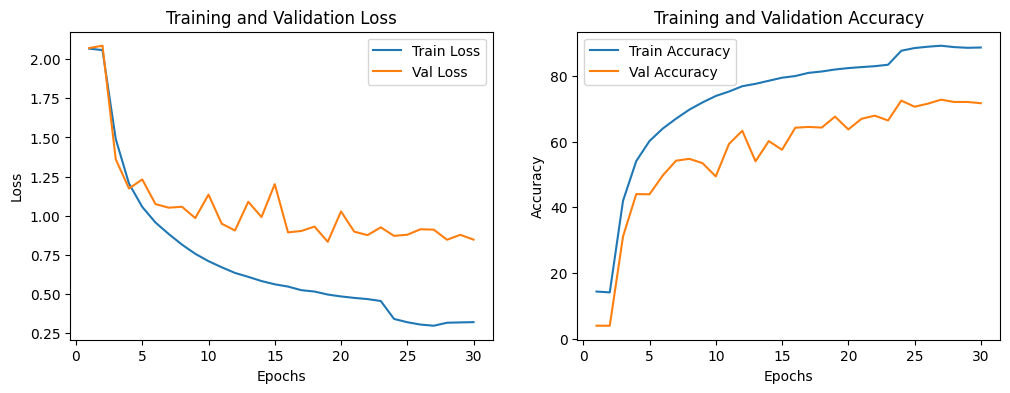

time: 374 ms (started: 2024-09-05 11:16:13 -04:00)


In [45]:
# Visualize the metrics
plot_metrics(metrics)

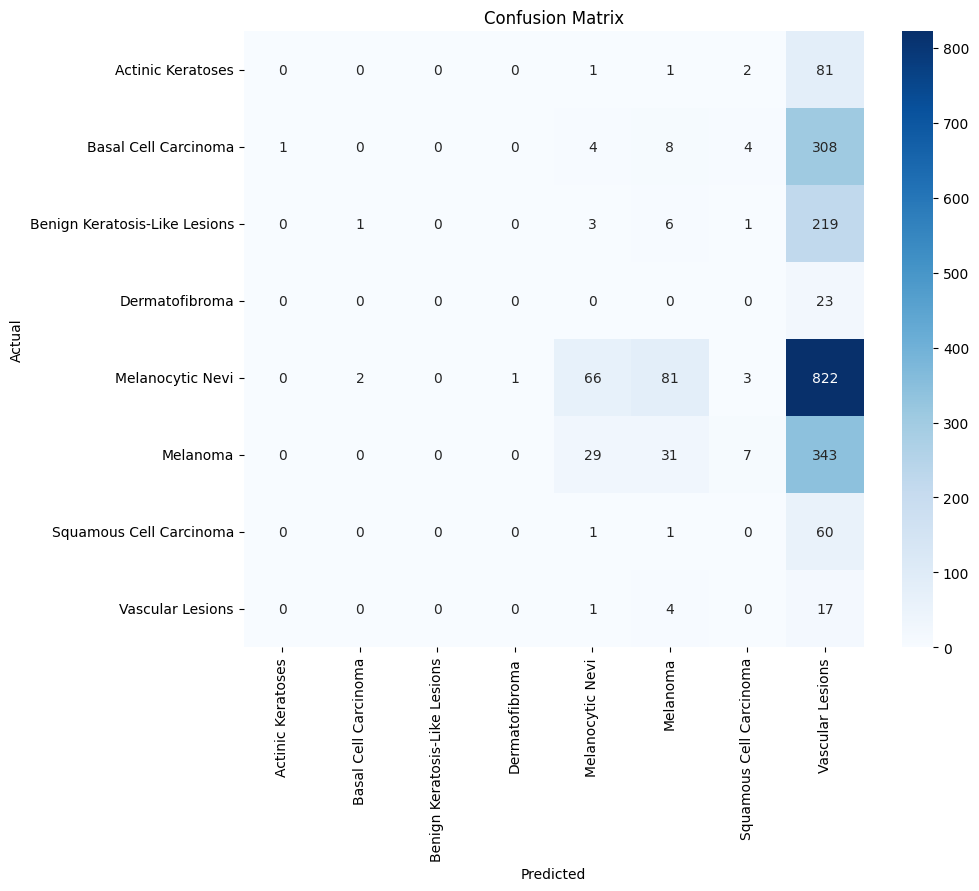

time: 16.2 s (started: 2024-09-05 11:16:13 -04:00)


In [46]:
# Plot the confusion matrix
plot_confusion_matrix(model, test_loader, label_mapping)

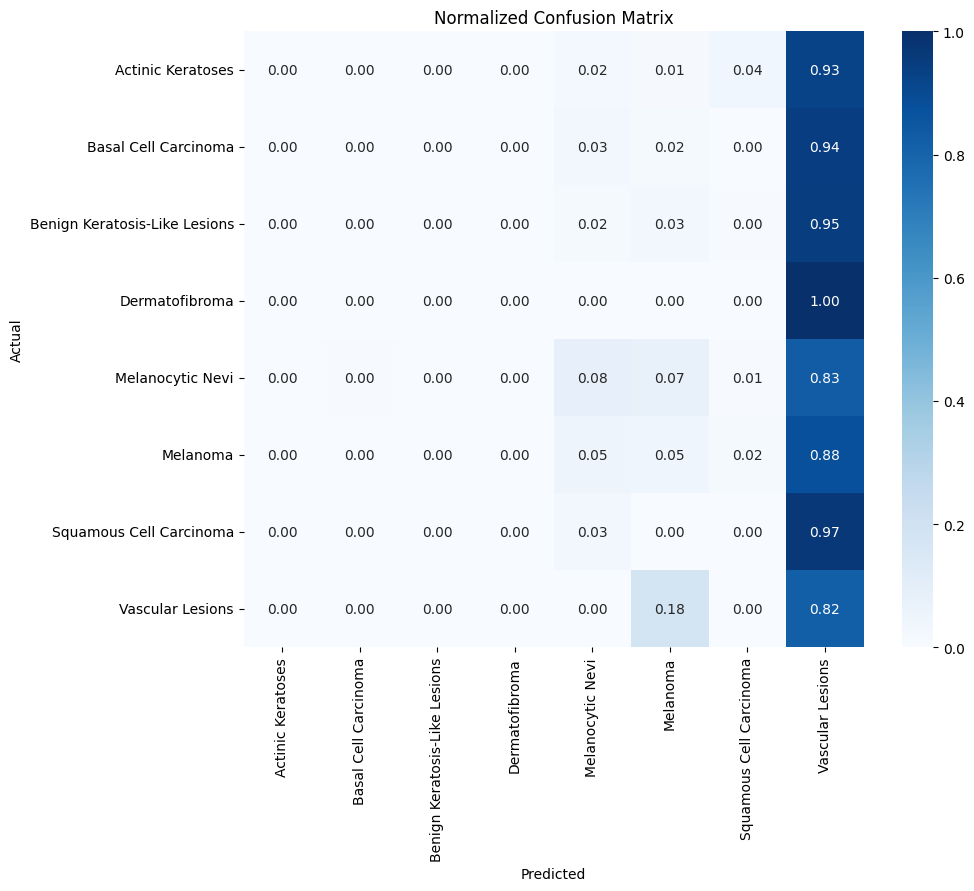

time: 15.4 s (started: 2024-09-05 11:16:29 -04:00)


In [47]:
# Plot the normalized confusion matrix
plot_normalize_confusion_matrix(model, test_loader, label_mapping)

In [44]:
# torch.cuda.empty_cache()

# Construct the model for training process
model_name = 'efficientnet-b0'
num_classes = len(label_mapping)
unfreeze_layers = 9  # Number of additional layers to unfreeze

model = create_model(model_name, num_classes, unfreeze_layers)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)  # Move the model to the device

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Transfer learning model
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Configuration for training process
num_epochs = 50
threshold = 0.5
patience = 10
save_dir = 'saved_models'  # Save the best model to this location

Loaded pretrained weights for efficientnet-b0
time: 194 ms (started: 2024-09-05 10:57:18 -04:00)


In [52]:
# Start training
metrics = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience=patience, threshold=threshold, save_dir=save_dir)

Epoch 1/50: 100%|███████████████████████████████████████████████████████████████████| 1949/1949 [14:18<00:00,  2.27it/s, Train Loss=0.3863, Train Accuracy=87.12%, Val Loss=0.7994, Val Accuracy=66.87%]


Model efficientnet-b0 at epoch 1 with accuracy of 66.96% and loss of 0.7694 is saved to "saved_models/efficientnet-b0_best.pth" successfully.


Epoch 2/50: 100%|███████████████████████████████████████████████████████████████████| 1949/1949 [14:39<00:00,  2.22it/s, Train Loss=0.3828, Train Accuracy=87.32%, Val Loss=0.7939, Val Accuracy=66.49%]


Model efficientnet-b0 at epoch 2 with accuracy of 67.01% and loss of 0.7890 is saved to "saved_models/efficientnet-b0_best.pth" successfully.


Epoch 3/50: 100%|███████████████████████████████████████████████████████████████████| 1949/1949 [14:27<00:00,  2.25it/s, Train Loss=0.3771, Train Accuracy=87.39%, Val Loss=0.7938, Val Accuracy=68.18%]


Model efficientnet-b0 at epoch 3 with accuracy of 67.39% and loss of 0.7811 is saved to "saved_models/efficientnet-b0_best.pth" successfully.


Epoch 7/50: 100%|███████████████████████████████████████████████████████████████████| 1949/1949 [14:28<00:00,  2.24it/s, Train Loss=0.3859, Train Accuracy=87.37%, Val Loss=0.7934, Val Accuracy=66.87%]


Model efficientnet-b0 at epoch 7 with accuracy of 67.67% and loss of 0.7741 is saved to "saved_models/efficientnet-b0_best.pth" successfully.


Epoch 13/50: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:38<00:00,  2.22it/s, Train Loss=0.3855, Train Accuracy=87.12%, Val Loss=0.7833, Val Accuracy=67.48%]


Model efficientnet-b0 at epoch 13 with accuracy of 68.23% and loss of 0.7750 is saved to "saved_models/efficientnet-b0_best.pth" successfully.


Epoch 16/50: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [14:29<00:00,  2.24it/s, Train Loss=0.3908, Train Accuracy=87.11%, Val Loss=0.7799, Val Accuracy=68.00%]


Model efficientnet-b0 at epoch 16 with accuracy of 68.28% and loss of 0.7937 is saved to "saved_models/efficientnet-b0_best.pth" successfully.


Epoch 17/50:  57%|█████████████████████████████████████▋                            | 1114/1949 [08:07<06:05,  2.28it/s, Train Loss=0.4526, Train Accuracy=85.07%, Val Loss=0.8125, Val Accuracy=64.57%]


KeyboardInterrupt: 

time: 5h 55min 9s (started: 2024-09-06 01:26:21 -04:00)


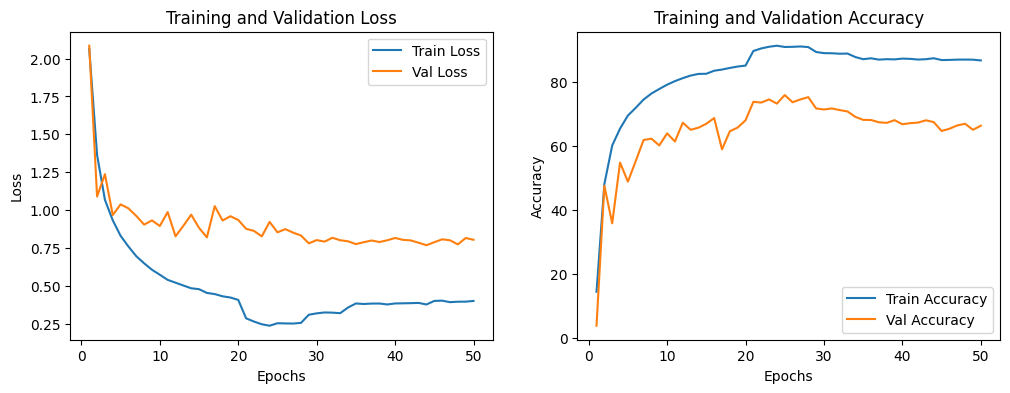

time: 379 ms (started: 2024-09-06 07:21:34 -04:00)


In [53]:
# Visualize the metrics
plot_metrics(metrics)

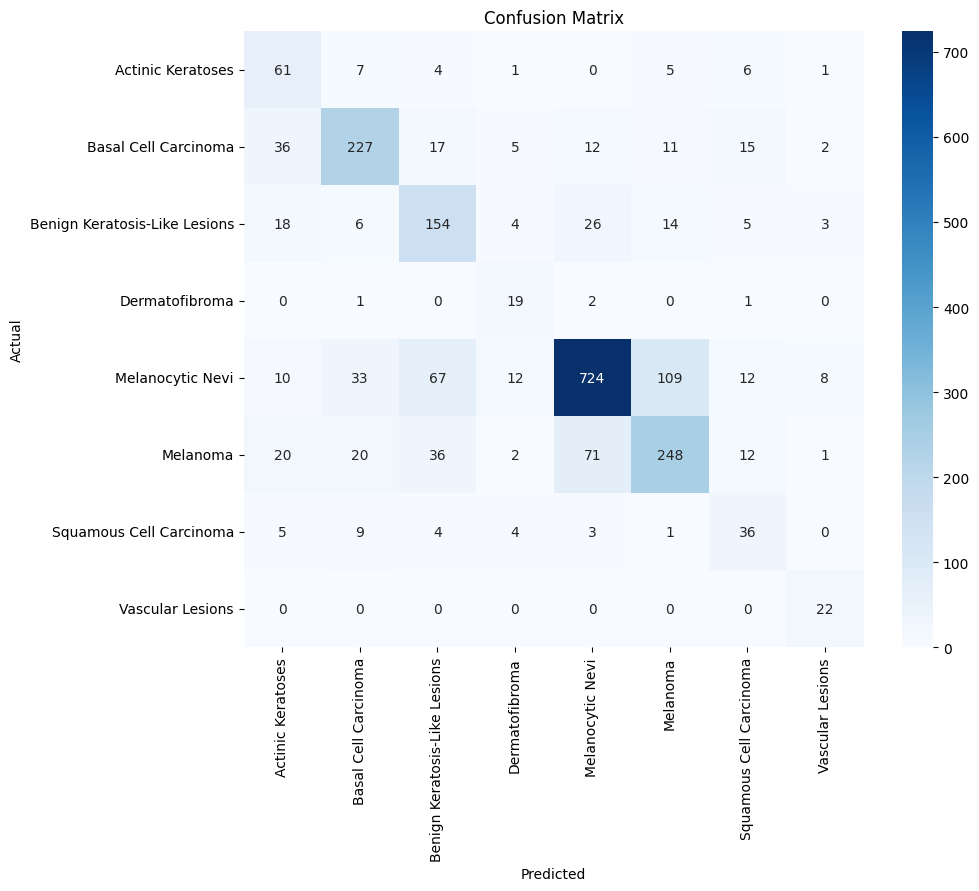

time: 16.1 s (started: 2024-09-06 07:22:27 -04:00)


In [56]:
# Plot the confusion matrix
plot_confusion_matrix(model, test_loader, label_mapping)

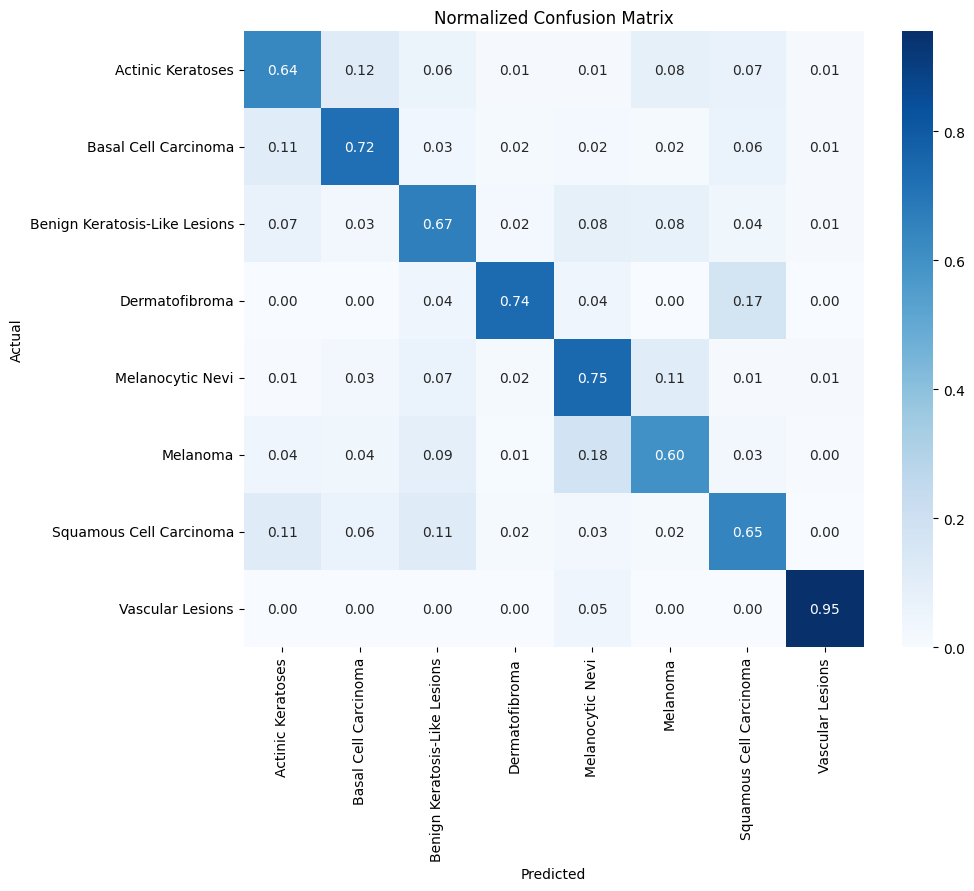

time: 16.4 s (started: 2024-09-06 07:22:43 -04:00)


In [57]:
# Plot the normalized confusion matrix
plot_normalize_confusion_matrix(model, test_loader, label_mapping)